### Cluster optimization with Furax


In [1]:
import os

os.environ["EQX_ON_ERROR"] = "nan"  # Needed to avoid Lineax CG throwing during the backward pass

from functools import partial

import healpy as hp
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from furax import HomothetyOperator
from furax.comp_sep import negative_log_likelihood, spectral_cmb_variance
from furax.obs.stokes import Stokes
from jax_grid_search import optimize
from jax_healpy import get_clusters

In [2]:
def allclose(x, y, rtol=1e-05, atol=1e-08, equal_nan=False) -> bool:
    return jax.tree.all(
        jax.tree.map(
            lambda x, y: jnp.allclose(x, y, rtol=rtol, atol=atol, equal_nan=equal_nan),
            x,
            y,
        ),
        True,
    )

### **Generate and Cache c1d1s1 Maps with Noise**

Pregenerates and caches `c1d1s1` sky maps with noise. This step ensures the required data is locally available for High-Performance Computing (HPC) clusters, where compute nodes typically lack direct internet access. Run this step on the front node before submitting jobs to the compute nodes.

In [3]:
import sys

sys.path.append("../data")
from generate_maps import get_mask, save_to_cache

nsides = [32, 64, 128]
for nside in nsides:
    save_to_cache(nside, sky="c1d1s1", noise=True)

Loaded freq_maps for nside 32 from cache.
Loaded freq_maps for nside 64 from cache.
Loaded freq_maps for nside 128 from cache.


### **Load Planck Masks (nside 64)**

Loads Planck masks (`GAL020`, `GAL040`, `GAL060`) that have been downgraded to an `nside` of 64 for compatibility with the resolution of subsequent analyses.

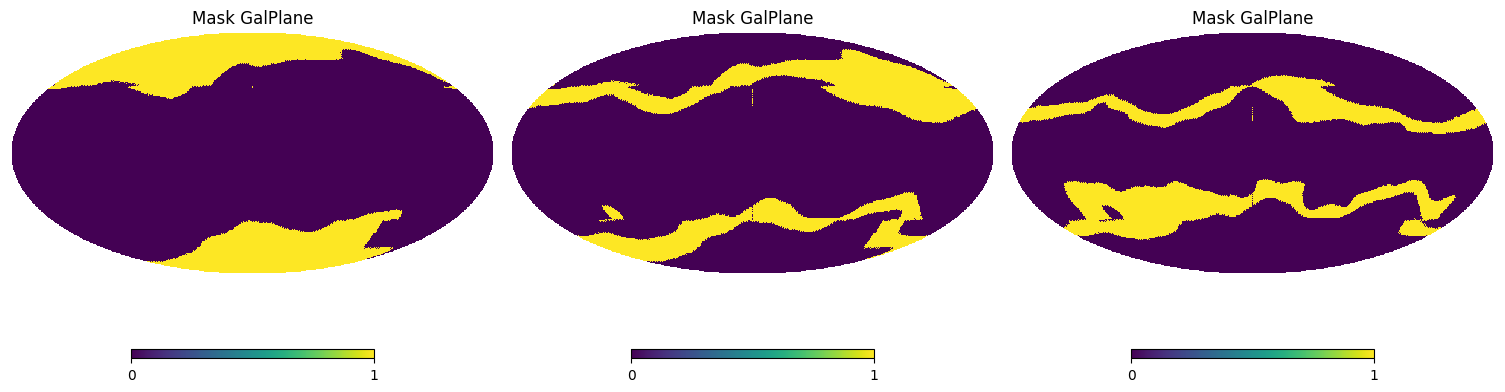

In [4]:
GAL020 = get_mask("GAL020", nside=64)
GAL040 = get_mask("GAL040", nside=64)
GAL060 = get_mask("GAL060", nside=64)

figure = plt.figure(figsize=(15, 15))
hp.mollview(GAL020, title="Mask GalPlane", sub=(1, 3, 1))
hp.mollview(GAL040, title="Mask GalPlane", sub=(1, 3, 2))
hp.mollview(GAL060, title="Mask GalPlane", sub=(1, 3, 3))

### **Load Cached Maps and Prepare Polarization Data**

we will work with `nside = 64` for the analysis in this notebook. It loads the cached `c1d1s1` sky maps with noise and focuses exclusively on the polarization components (`Q` and `U`) for component separation, excluding intensity data.

In [5]:
from generate_maps import load_from_cache

nside = 64
npixels = 12 * nside**2

nu, freq_maps = load_from_cache(nside, sky="c1d1s1", noise=True)
print("freq_maps shape:", freq_maps.shape)

d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])
print(f"Structure of D Matrix : {d.structure}")

Loaded freq_maps for nside 64 from cache.
freq_maps shape: (15, 3, 49152)
Structure of D Matrix : StokesQU(q=ShapeDtypeStruct(shape=(15, 49152), dtype=float64), u=ShapeDtypeStruct(shape=(15, 49152), dtype=float64))


### **Clustering Full and Masked Maps**

Demonstrates the clustering process on sky maps. Clustering can be applied to:  
1. **Full Map:** The entire map without any masking.  
2. **Masked Map:** Only the regions defined by the `GAL020` mask.  

Visualizations compare clustering results for both cases.

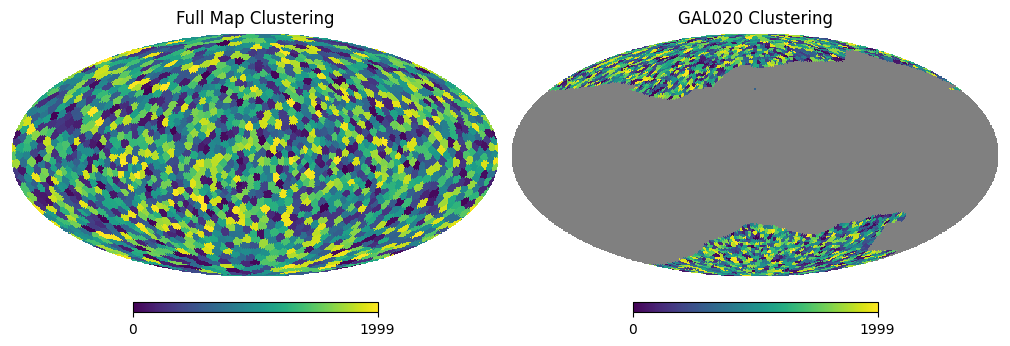

In [6]:
mask = jnp.ones(npixels)
(indices,) = jnp.where(mask == 1)

full_map = get_clusters(mask, indices, 2000, jax.random.PRNGKey(0), max_centroids=2000)

(indices,) = jnp.where(GAL020 == 1)
GAL020_clusters = get_clusters(GAL020, indices, 2000, jax.random.PRNGKey(0), max_centroids=2000)

# Set up subplots
fig = plt.figure(figsize=(10, 5))
# Plot each map
hp.mollview(full_map, title="Full Map Clustering", sub=(1, 2, 1), bgcolor=(1.0,) * 4)
hp.mollview(GAL020_clusters, title="GAL020 Clustering", sub=(1, 2, 2), bgcolor=(1.0,) * 4)
# Display the plot
plt.show()

### **Performance Benchmark for `get_clusters`**

Benchmarks the `get_clusters` function using `%timeit`. The function is optimized for performance and can be **JIT-compiled** when the `max_centroids` parameter is set as a static value.

In [7]:
%timeit get_clusters(mask,indices ,1000, jax.random.PRNGKey(0),max_centroids=1000)

1.83 s ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### **Clustering for Parameter Patches**

Clusters the `GAL020` mask into patches corresponding to three physical parameters:  
1. **Dust Temperature (`temp_dust`)**  
2. **Dust Spectral Index (`beta_dust`)**  
3. **Power-law Spectral Index (`beta_pl`)**

Each parameter is assigned a fixed number of patches, and cluster indices are computed using `get_clusters`. 

The parameter values and their corresponding patch indices are stored in dictionaries for easy reference. Visualizations show the clustering results for each parameter.

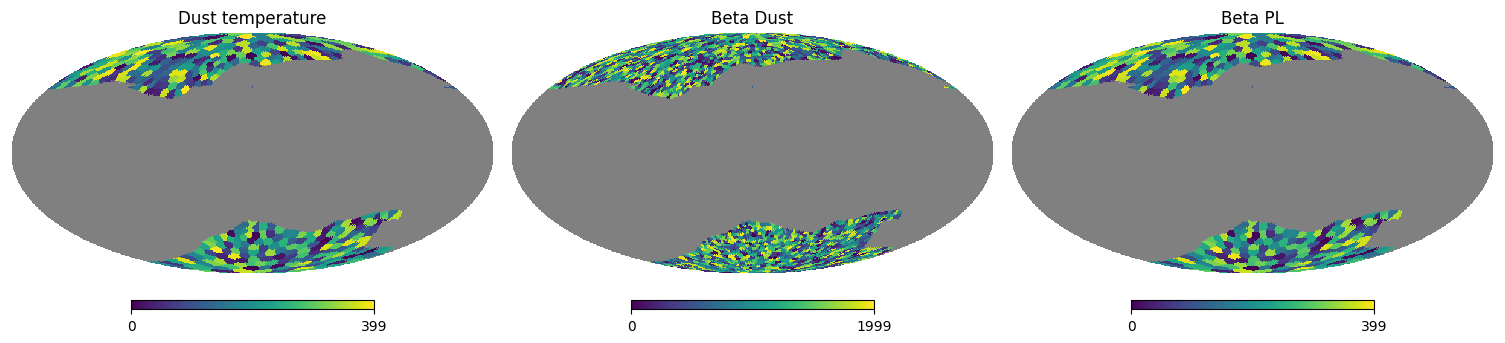

In [8]:
temp_dust_patches_count = 400
beta_dust_patches_count = 2000
beta_pl_patches_count = 400
max_centroids = 2000

mask = GAL020
(indices,) = jnp.where(mask == 1)
temp_dust_patch_indices = get_clusters(
    mask,
    indices,
    temp_dust_patches_count,
    jax.random.PRNGKey(0),
    max_centroids=max_centroids,
)
beta_dust_patch_indices = get_clusters(
    mask,
    indices,
    beta_dust_patches_count,
    jax.random.PRNGKey(0),
    max_centroids=max_centroids,
)
beta_pl_patch_indices = get_clusters(
    mask,
    indices,
    beta_pl_patches_count,
    jax.random.PRNGKey(0),
    max_centroids=max_centroids,
)

params = {
    "temp_dust": jnp.full((temp_dust_patches_count,), 20.0),
    "beta_dust": jnp.full((beta_dust_patches_count,), 1.54),
    "beta_pl": jnp.full((beta_pl_patches_count,), -3.0),
}

patch_indices = {
    "temp_dust_patches": temp_dust_patch_indices,
    "beta_dust_patches": beta_dust_patch_indices,
    "beta_pl_patches": beta_pl_patch_indices,
}

# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(temp_dust_patch_indices, title="Dust temperature", sub=(1, 3, 1), bgcolor=(1.0,) * 4)
hp.mollview(beta_dust_patch_indices, title="Beta Dust", sub=(1, 3, 2), bgcolor=(1.0,) * 4)
hp.mollview(beta_pl_patch_indices, title="Beta PL", sub=(1, 3, 3), bgcolor=(1.0,) * 4)

# Display the plot
plt.show()

### **Extract Unmasked Pixels to Reduce Problem Size**

The `get_cutout_from_mask` function is used to extract only the unmasked pixels from the data (`d`) and the cluster indices (`patch_indices`). This reduces the problem size by focusing computations on relevant regions defined by the `GAL020` mask.

**Observation:**  
- Original data shape: `(15, 49152)`  
- Cutout shape (unmasked pixels): `(15, 10068)`  



In [9]:
from jax_healpy import from_cutout_to_fullmap, get_cutout_from_mask

(indices,) = jnp.where(GAL020 == 1)

masked_sky = get_cutout_from_mask(d, indices, axis=1)
masked_clusters = get_cutout_from_mask(patch_indices, indices)
masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int32), masked_clusters)

print(f"shape of d is {d.shape} and shape of the cutout is {masked_sky.shape}")

shape of d is (15, 49152) and shape of the cutout is (15, 10074)


### **Mapping Parameters to Healpix Pixelation**

Maps patch-based parameters back to Healpix pixelation using the structure of `params` and `masked_clusters`. This step prepares parameter values for compatibility with Healpix-based operations.

In [10]:
params_struct = jax.tree.structure(params)
patches_pytree = jax.tree.unflatten(params_struct, jax.tree.leaves(masked_clusters))

modified_params = jax.tree.map_with_path(
    lambda path, v: v + jr.normal(jr.key(path[0].key.__hash__()), v.shape) * 0.1, params
)

params_mapped = jax.tree.map(lambda p, ind: p[ind], modified_params, patches_pytree)

print("shape of params Before mapping is ")
_ = jax.tree.map_with_path(lambda path, v: print(f"{path[0].key} : {v.shape}"), params)
print("shape of params After mapping is ")
_ = jax.tree.map_with_path(lambda path, v: print(f"{path[0].key} : {v.shape}"), params_mapped)

shape of params Before mapping is 
beta_dust : (2000,)
beta_pl : (400,)
temp_dust : (400,)
shape of params After mapping is 
beta_dust : (10074,)
beta_pl : (10074,)
temp_dust : (10074,)


### **Visualizing Parameters Mapped Back to Healpix**

This cell maps the computed parameters (`params_mapped`) back to the full Healpix pixelation for visualization. Using the `GAL020` mask and `from_cutout_to_fullmap`, the patch-based parameters are reconstructed to match the Healpix grid.

**Visualization:**  
- `temp_dust`, `beta_dust`, and `beta_pl` parameters are displayed on Mollweide projections to confirm their distribution across the sky.

shape of params After bringing back to full map is 
beta_dust : (49152,)
beta_pl : (49152,)
temp_dust : (49152,)


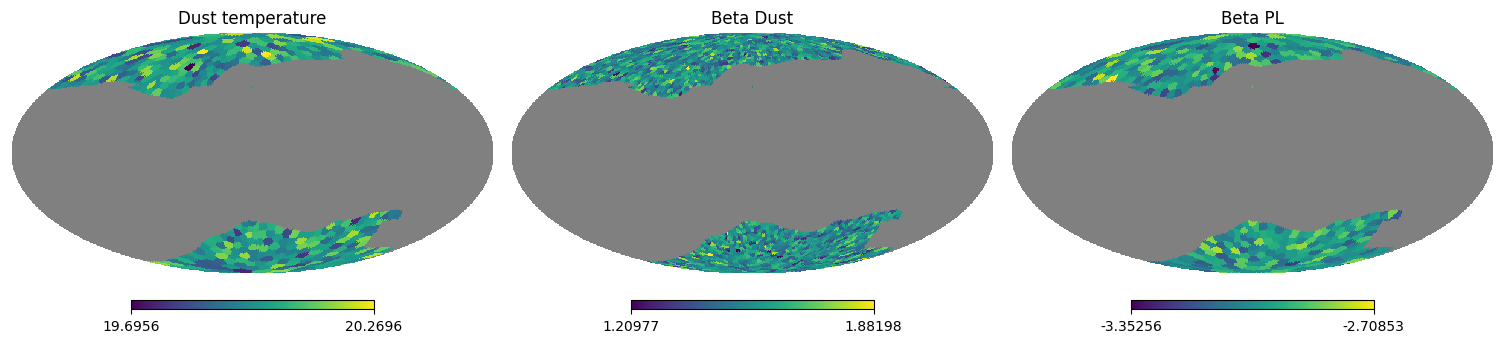

In [11]:
(indices,) = jnp.where(GAL020 == 1)
healpix_params = from_cutout_to_fullmap(params_mapped, indices, nside=64)

print("shape of params After bringing back to full map is ")
jax.tree.map_with_path(lambda path, v: print(f"{path[0].key} : {v.shape}"), healpix_params)

# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(
    healpix_params["temp_dust"],
    title="Dust temperature",
    sub=(1, 3, 1),
    bgcolor=(1.0,) * 4,
)
hp.mollview(healpix_params["beta_dust"], title="Beta Dust", sub=(1, 3, 2), bgcolor=(1.0,) * 4)
hp.mollview(healpix_params["beta_pl"], title="Beta PL", sub=(1, 3, 3), bgcolor=(1.0,) * 4)

# Display the plot
plt.show()

In [12]:
_ = jax.tree.map_with_path(lambda path, v: print(f"{path[0].key} : {v.shape}"), params)
print("=" * 50)
_ = jax.tree.map_with_path(lambda path, v: print(f"{path[0].key} : {v.shape}"), masked_clusters)
print("=" * 50)
print(f"shape of the masked D matrix is {masked_sky.shape}")

beta_dust : (2000,)
beta_pl : (400,)
temp_dust : (400,)
beta_dust_patches : (10074,)
beta_pl_patches : (10074,)
temp_dust_patches : (10074,)
shape of the masked D matrix is (15, 10074)


### **Setting Up Objective Functions**

Initializes the objective functions `negative_log_likelihood` and `spectral_cmb_variance` with fixed reference frequencies:  
- **Synchrotron:** `synchrotron_nu0 = 20.0 GHz`  
- **Dust:** `dust_nu0 = 150.0 GHz`  

These functions are reused from the first notebook for consistency in the analysis.

In [13]:
dust_nu0 = 150.0
synchrotron_nu0 = 20.0
negative_log_likelihood = partial(
    negative_log_likelihood, synchrotron_nu0=synchrotron_nu0, dust_nu0=dust_nu0
)
spectral_cmb_variance = partial(
    spectral_cmb_variance, synchrotron_nu0=synchrotron_nu0, dust_nu0=dust_nu0
)

### **Optimization to Minimize Negative Log-Likelihood**

This cell performs optimization to minimize the `negative_log_likelihood` using the `optax.lbfgs` solver. The process adjusts parameter values for better model fitting.

**Key Steps:**  
1. **Solver Initialization:**  
   - Uses `optax.lbfgs()` for gradient-based optimization with a tolerance of `1e-10` and a maximum of 2000 iterations.

2. **Optimization Function:**  
   - `optimize` function minimizes the `negative_log_likelihood` with the given data (`masked_sky`) and patch indices (`masked_clusters`).

3. **Results:**  
   - **Number of evaluations:** Tracks optimization steps using `otu.tree_get`.  
   - **CMB Variance:** Computes the variance in the Cosmic Microwave Background (CMB) signal using the optimized parameters.

This step refines the parameter estimates to fit the data while quantifying the CMB variance.

In [15]:
import optax
import optax.tree_utils as otu
from jax_grid_search import ProgressBar
from rich.progress import BarColumn, TimeElapsedColumn, TimeRemainingColumn

solver = optax.lbfgs()
N = HomothetyOperator(jnp.ones(1), _in_structure=masked_sky.structure)

lower_bound = {
    "beta_dust": 1.0,
    "temp_dust": 10.0,
    "beta_pl": -5.0,
}
upper_bound = {
    "beta_dust": 3.0,
    "temp_dust": 30.0,
    "beta_pl": 0.0,
}

lower_bound_tree = jax.tree.map(lambda v, c: jnp.full(c.shape, v), lower_bound, params)
upper_bound_tree = jax.tree.map(lambda v, c: jnp.full(c.shape, v), upper_bound, params)

progress_columns = [
    "[progress.description]{task.description}",
    BarColumn(),
    "[progress.percentage]{task.percentage:>3.0f}%",
    TimeElapsedColumn(),
    TimeRemainingColumn(),
]

with ProgressBar(*progress_columns) as p:
    final_params, final_state = optimize(
        params,
        negative_log_likelihood,
        solver,
        max_iter=1000,
        tol=1e-10,
        lower_bound=lower_bound_tree,
        upper_bound=upper_bound_tree,
        progress=p,
        nu=nu,
        N=N,
        d=masked_sky,
        patch_indices=masked_clusters,
    )


print(f"number of evaluations: {otu.tree_get(final_state, 'count')}")
cmb_variance = spectral_cmb_variance(
    final_params, nu=nu, d=masked_sky, N=N, patch_indices=masked_clusters
)
print(f"cmb_variance Value: {cmb_variance}")

Output()

number of evaluations: 36
cmb_variance Value: 1.0024625190995284


In [16]:
import jaxopt

scipy_solver = jaxopt.ScipyMinimize(fun=negative_log_likelihood, method="TNC", jit=True, tol=1e-10)
result = scipy_solver.run(params, nu=nu, N=N, d=masked_sky, patch_indices=masked_clusters)
result.params

/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/jaxopt/_src/scipy_wrappers.py:343: OptimizeWarning: Unknown solver options: maxiter
  res = osp.optimize.minimize(scipy_fun, jnp_to_onp(init_params, self.dtype),


{'beta_dust': Array([1.54050161, 1.58615587, 1.52828075, ..., 1.57724917, 1.53468702,
        1.54299011], dtype=float64),
 'beta_pl': Array([-3.03163175, -2.95920925, -3.00862338, -3.02806909, -3.02935938,
        -2.92469298, -3.04528889, -2.98025369, -2.98990663, -3.00656024,
        -2.99239546, -3.00616891, -3.00372266, -3.0098161 , -3.04872377,
        -2.98779488, -3.00489443, -2.98251337, -3.07620758, -3.02800375,
        -2.96539043, -2.99760541, -3.00598526, -3.02557156, -3.01386795,
        -3.00290862, -3.01499193, -3.06556614, -3.00201816, -2.98745255,
        -3.03653721, -3.02491417, -3.03511831, -3.05419921, -3.0150013 ,
        -2.97711566, -3.01072073, -3.04665645, -3.04202275, -2.99241909,
        -2.99240685, -3.01607347, -3.01393279, -3.01666173, -3.02770099,
        -2.99418711, -3.01041637, -3.01496408, -3.05215728, -2.92903476,
        -3.02409531, -3.04779683, -2.96419863, -2.99562595, -3.09643563,
        -2.9659393 , -3.04859731, -3.01314047, -2.9982895 , -3.

__Note:__  
The solver stops when the step size reaches the specified tolerance or the maximum number of iterations. It also intelligently tracks and retains the best parameters encountered, even if later steps diverge.

### **Validating Optimization Results**

Checks if the best value found during optimization is better than the last computed value. Compares negative log-likelihood for the best and last parameters

In [17]:
print(f"Is Best value less from last value {final_state.best_val <= final_state.value}")

last_nll = negative_log_likelihood(
    final_state.params, d=masked_sky, nu=nu, N=N, patch_indices=masked_clusters
)
best_nll = negative_log_likelihood(
    final_state.best_params, d=masked_sky, nu=nu, N=N, patch_indices=masked_clusters
)

print(f"Are best params better than last params {best_nll <= last_nll}")

Is Best value less from last value True
Are best params better than last params True


This cell performs a simple numerical check to ensure the best parameters (`p`) found during optimization correspond to a local minimum of the negative log-likelihood.  

**Steps:**  
1. Perturbs the parameters slightly in both positive (`final_params_p`) and negative (`final_params_m`) directions.  
2. Compares the negative log-likelihood of the perturbed parameters (`higher_p` and `higher_m`) with the minimum value.  

The test confirms that the NLL at `p` is lower than at the perturbed points, validating optimality.

In [18]:
p = final_state.params
minimum = negative_log_likelihood(p, d=masked_sky, nu=nu, N=N, patch_indices=masked_clusters)

final_params_p = jax.tree.map(lambda x: x + 1e-7, p)
final_params_m = jax.tree.map(lambda x: x - 1e-7, p)

higher_p = negative_log_likelihood(
    final_params_p, d=masked_sky, nu=nu, N=N, patch_indices=masked_clusters
)
higher_m = negative_log_likelihood(
    final_params_m, d=masked_sky, nu=nu, N=N, patch_indices=masked_clusters
)


higher_p > minimum < higher_m

Array(True, dtype=bool)

### **Exploring Cluster Counts for Beta Dust Patches**

This section evaluates the effect of varying the number of `beta_dust` clusters (from 100 to 1000) on the optimization results. Other patches (`temp_dust` and `beta_pl`) are kept constant with 100 clusters each. For each configuration, the optimization process runs, and the resulting CMB variance is recorded to determine the optimal cluster count for `beta_dust`.


In [38]:
from IPython.display import clear_output

(indices,) = jnp.where(GAL020 == 1)
cmb_vars = []
beta_dust_clusters = []
params_list = []
patches_list = []

max_centroids = 1000
temp_dust_patches = 1
beta_pl_patches_count = 1

params = {
    "temp_dust": jnp.full((temp_dust_patches,), 20.0),
    "beta_dust": jnp.full((max_centroids,), 1.54),
    "beta_pl": jnp.full((beta_pl_patches_count,), -3.0),
}

lower_bound_tree = jax.tree.map(lambda v, c: jnp.full(c.shape, v), lower_bound, params)
upper_bound_tree = jax.tree.map(lambda v, c: jnp.full(c.shape, v), upper_bound, params)


for cluster_count in range(100, 1001, 50):
    clear_output(wait=True)
    print(f"Running for {cluster_count} clusters")
    beta_dust_patch_indices = get_clusters(
        GAL020,
        indices,
        cluster_count,
        jax.random.PRNGKey(0),
        max_centroids=max_centroids,
    )

    beta_dust_patch_indices = get_cutout_from_mask(beta_dust_patch_indices, indices)
    beta_dust_patch_indices = beta_dust_patch_indices.astype(jnp.int32)

    masked_clusters["beta_dust_patches"] = beta_dust_patch_indices

    progress_columns = [
        "[progress.description]{task.description}",
        BarColumn(),
        "[progress.percentage]{task.percentage:>3.0f}%",
        TimeElapsedColumn(),
        TimeRemainingColumn(),
    ]

    solver = optax.lbfgs()

    with ProgressBar(*progress_columns) as p:
        final_params, final_state = optimize(
            params,
            negative_log_likelihood,
            solver,
            max_iter=200,
            tol=1e-10,
            lower_bound=lower_bound_tree,
            upper_bound=upper_bound_tree,
            progress=p,
            nu=nu,
            N=N,
            d=masked_sky,
            patch_indices=masked_clusters,
        )

    cmb_variance = spectral_cmb_variance(
        final_params, nu=nu, d=masked_sky, N=N, patch_indices=masked_clusters
    )
    cmb_vars.append(cmb_variance)
    beta_dust_clusters.append(cluster_count)
    params_list.append(final_params)
    patches_list.append(masked_clusters)

Running for 1000 clusters


Output()

### **Visualizing CMB Variance vs. Beta Dust Clusters**

Plots the relationship between the number of `beta_dust` clusters and the resulting CMB variance.  

**Key Elements:**  
- **X-axis:** Number of clusters for `beta_dust`.  
- **Y-axis:** Computed CMB variance.  
- **Objective:** Identify the optimal cluster count that minimizes the CMB variance.  

This visualization helps assess the trade-off between model complexity (number of clusters) and performance (CMB variance).

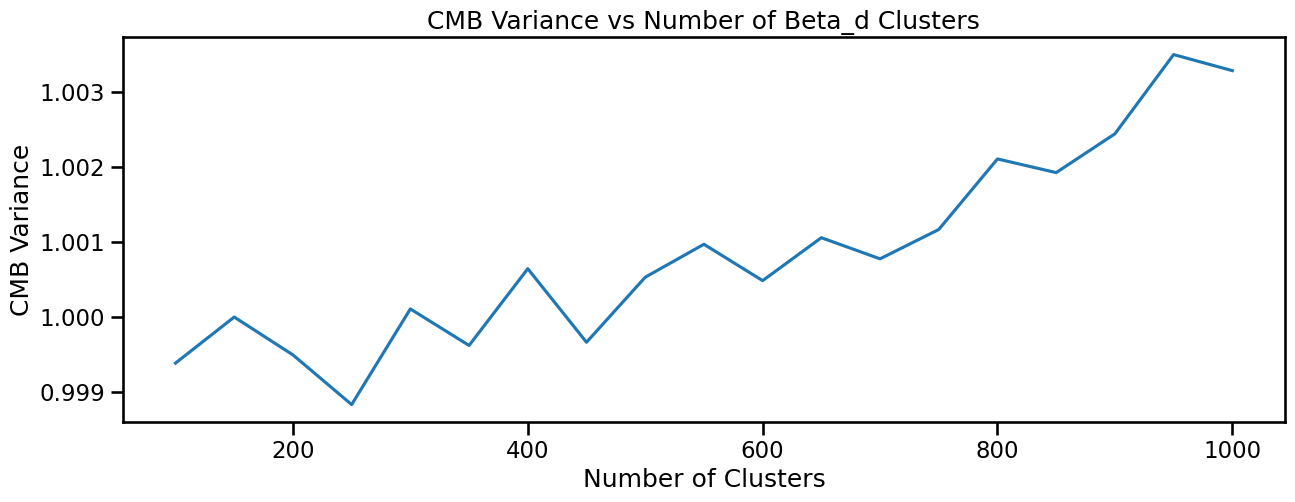

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

fig = plt.figure(figsize=(15, 5))
X = beta_dust_clusters
Y = cmb_vars
plt.plot(X, Y)
plt.xlabel("Number of Clusters")
plt.ylabel("CMB Variance")
plt.title("CMB Variance vs Number of Beta_d Clusters")
plt.show()

### **Mapping Optimal Parameters Back to Healpix**

Maps the parameters corresponding to the lowest CMB variance back to the full Healpix grid and visualizes `temp_dust`, `beta_dust`, and `beta_pl`.

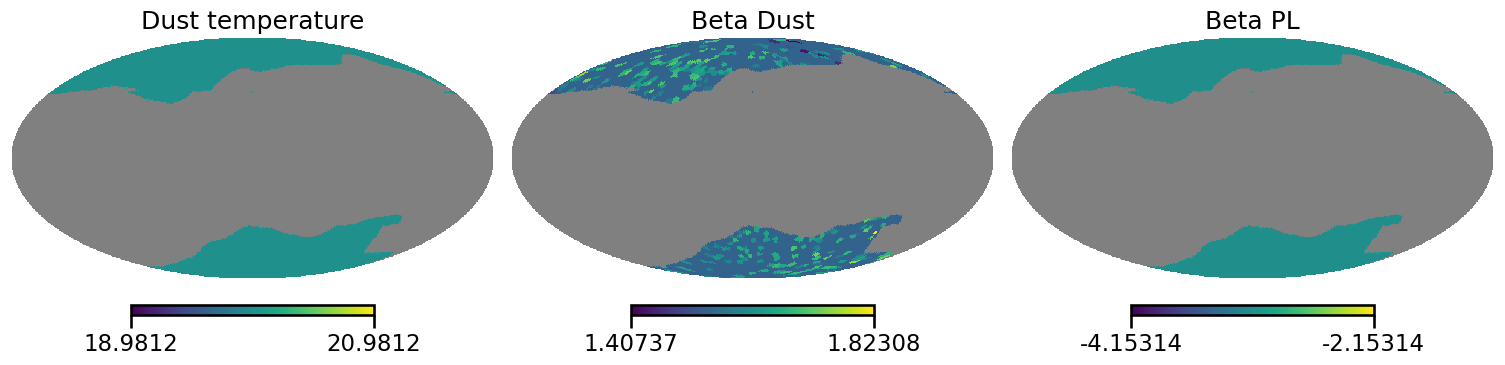

In [42]:
best_variance = jnp.argmin(jnp.array(cmb_vars))
best_params = params_list[best_variance]

patches_pytree = jax.tree.unflatten(params_struct, jax.tree.leaves(masked_clusters))
params_mapped = jax.tree.map(lambda p, ind: p[ind], best_params, patches_pytree)

(indices,) = jnp.where(GAL020 == 1)
healpix_params = from_cutout_to_fullmap(params_mapped, indices, nside=64)
# Set up subplots
fig = plt.figure(figsize=(15, 5))
# Plot each map
hp.mollview(
    healpix_params["temp_dust"],
    title="Dust temperature",
    sub=(1, 3, 1),
    bgcolor=(1.0,) * 4,
)
hp.mollview(healpix_params["beta_dust"], title="Beta Dust", sub=(1, 3, 2), bgcolor=(1.0,) * 4)
hp.mollview(healpix_params["beta_pl"], title="Beta PL", sub=(1, 3, 3), bgcolor=(1.0,) * 4)

# Display the plot
plt.show()